In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [25]:
data = pd.read_csv('X_train.csv')
test = pd.read_csv('X_test.csv')
target = pd.read_csv('y_train.csv')
subsample = pd.read_csv('sample_submission.csv')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(487680, 13)
(488448, 13)
(3810, 3)


In [26]:
subsample.head()

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete


In [27]:
target.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [28]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [32]:
len(data['series_id'].unique())

3810

In [44]:
len(test['series_id'].unique())

3816

### Test data has 6 series id more than the training data

.

In [45]:
len(data['measurement_number'].unique())

128

### Each series has 128 measurements

.

In [29]:
data['series_id'].unique()[-1]

3809

In [38]:
data.isnull().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [39]:
test.isnull().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [40]:
target.isnull().sum()

series_id    0
group_id     0
surface      0
dtype: int64

In [37]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


In [41]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
series_id,488448.0,1907.500000,1101.585403,0.00000,953.750000,1907.500000,2861.250000,3815.00000
measurement_number,488448.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,488448.0,0.031996,0.671977,-0.98972,-0.648130,0.132910,0.575270,0.98932
orientation_Y,488448.0,0.120651,0.714522,-0.98981,-0.744503,0.397860,0.803600,0.98894
orientation_Z,488448.0,0.018735,0.108481,-0.15468,-0.112660,0.057271,0.124770,0.15425
orientation_W,488448.0,0.004024,0.100957,-0.15627,-0.098435,0.022654,0.083706,0.15251
angular_velocity_X,488448.0,0.000401,0.114485,-2.40330,-0.037396,0.001107,0.037827,3.39660
angular_velocity_Y,488448.0,0.013669,0.089440,-1.19300,-0.029865,0.007276,0.051112,1.15070
angular_velocity_Z,488448.0,-0.036101,0.233791,-1.45820,-0.089842,-0.008911,0.057876,0.96028
linear_acceleration_X,488448.0,0.125433,1.832639,-35.04000,-0.486233,0.112490,0.727250,36.62800


In [43]:
target.describe().T

,count,mean,std,min,25%,50%,75%,max
series_id,3810.0,1904.500000,1099.996591,0.0,952.25,1904.5,2856.75,3809.0
group_id,3810.0,37.601312,20.982743,0.0,19.00,39.0,55.00,72.0


#### If we look at the features: orientation, angular velocity and linear acceleration, we can see big differences between max and min from entire test vs 6 extra test's series (see linear_acceleration_Z).

#### Obviously we are comparing 3810 series vs 6 series so this is not a big deal.

.

In [56]:
target.groupby('group_id')['surface'].unique().max()

array(['wood'], dtype=object)

In [59]:
len(target['group_id'].unique())

73

In [68]:
target['surface'].value_counts().sort_values(ascending=False)

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

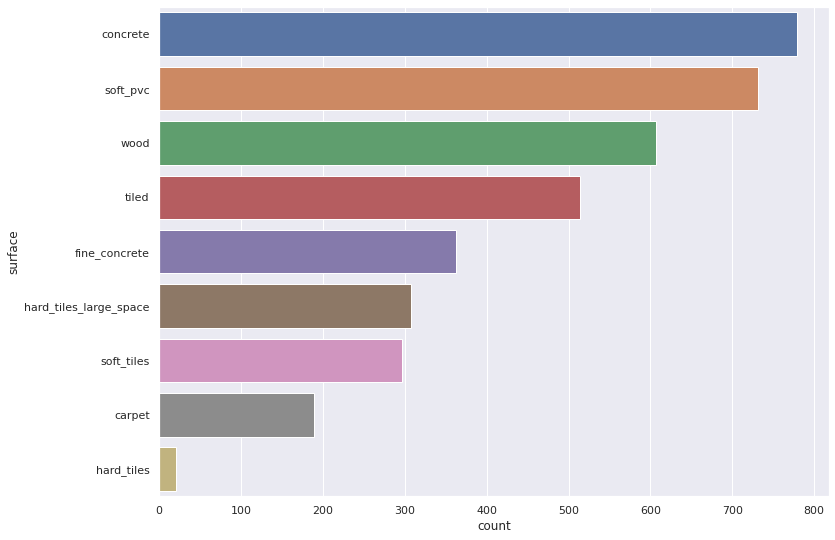

In [69]:
plt.subplots(figsize=(12, 9))
sns.countplot(y = 'surface', data = target, order=target['surface'].value_counts().index)
plt.show()

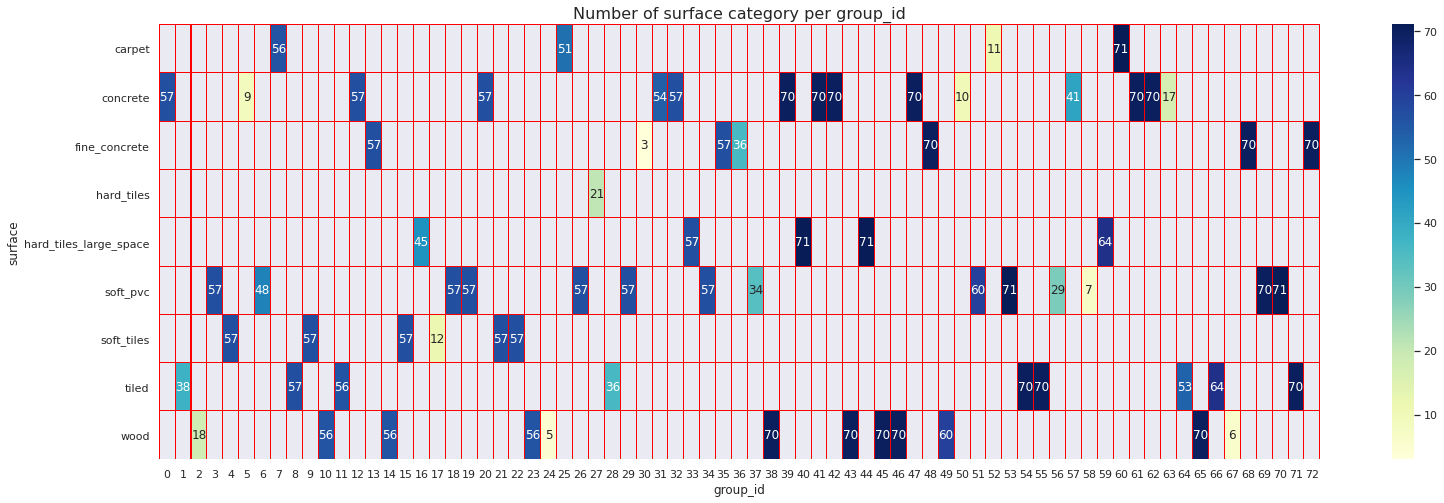

In [83]:
plt.subplots(1, 1, figsize=(26, 8))
tmp = pd.DataFrame(target.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.01, linecolor='red', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

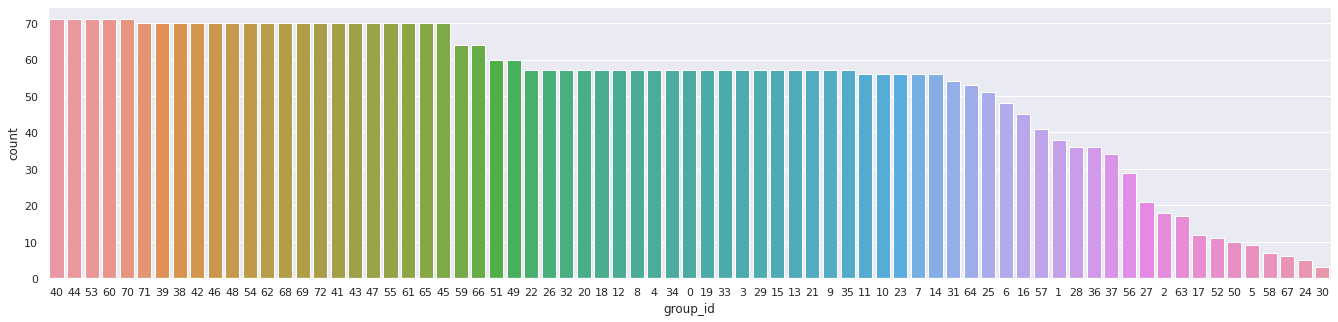

In [87]:
plt.figure(figsize=(23,5)) 
sns.countplot(x="group_id", data=target, order = target['group_id'].value_counts().index)
plt.show()

### So, we have 3810 train series, and 3816 test series. Let's engineer some features!

.

## Example: Series 0

In [96]:
serie0 = data.head(128)
serie0.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [97]:
serie0.describe().T

,count,mean,std,min,25%,50%,75%,max
series_id,128.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
measurement_number,128.0,63.500000,37.094474,0.000000,31.750000,63.500000,95.250000,127.000000
orientation_X,128.0,-0.758666,0.000363,-0.759530,-0.758927,-0.758530,-0.758367,-0.758220
orientation_Y,128.0,-0.634008,0.000471,-0.634560,-0.634383,-0.634270,-0.633530,-0.633060
orientation_Z,128.0,-0.105474,0.000432,-0.106140,-0.105873,-0.105500,-0.105077,-0.104610
orientation_W,128.0,-0.106470,0.000389,-0.107050,-0.106775,-0.106555,-0.106130,-0.105590
angular_velocity_X,128.0,-0.002481,0.052800,-0.160410,-0.029069,-0.005082,0.035803,0.107650
angular_velocity_Y,128.0,-0.003306,0.031544,-0.079404,-0.027110,-0.004037,0.020031,0.072698
angular_velocity_Z,128.0,0.007532,0.017127,-0.030181,-0.005289,0.006842,0.020088,0.051720
linear_acceleration_X,128.0,0.263418,0.911175,-1.864400,-0.362872,0.231665,0.905635,2.853800


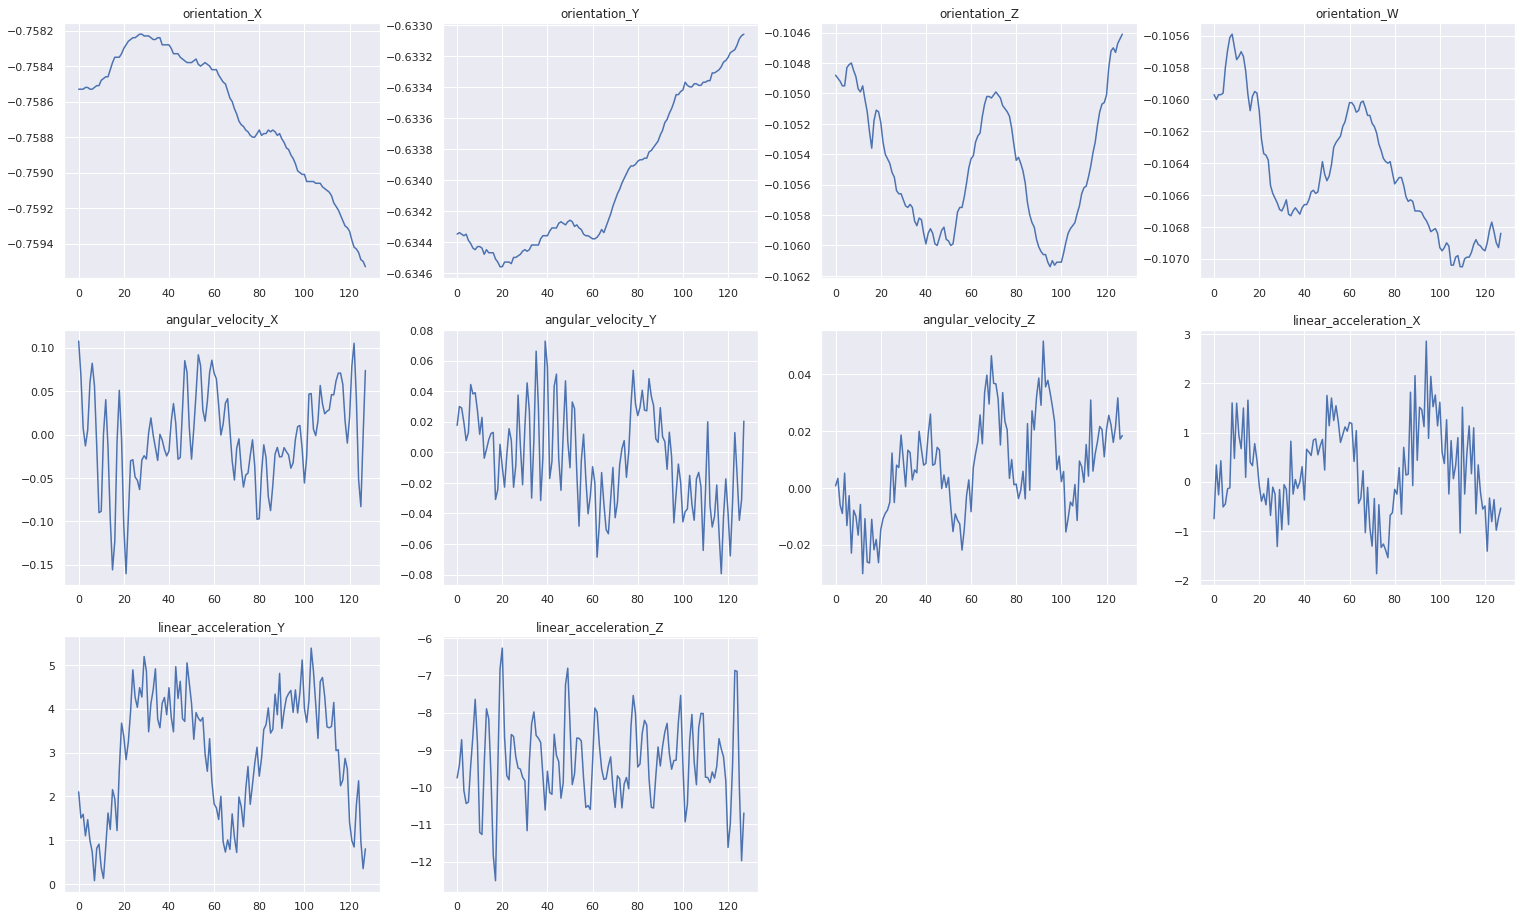

In [98]:
plt.subplots(figsize=(26, 16))
for i, col in enumerate(serie0.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(serie0[col])
    plt.title(col)

### In this example, we can see a quite interesting performance:

#### Orientation X increases
#### Orientation Y decreases
#### We don't see any kind of pattern except for linear_acceleration_Y
##### And we know that in this series, the robot moved throuh "fine_concrete".

.

In [95]:
target.head(1)

,series_id,group_id,surface
0,0,13,fine_concrete


# Visualizing (Orientation, Velocity, Acceleration) for all Series

In [99]:
series_dict = {}
for series in (data['series_id'].unique()):
    series_dict[series] = data[data['series_id'] == series]  

In [102]:
def plotSeries(series_id):
    plt.style.use('ggplot')
    plt.figure(figsize=(28, 16))
    print(target[target['series_id'] == series_id]['surface'].values[0].title())
    for i, col in enumerate(series_dict[series_id].columns[3:]):
        if col.startswith("o"):
            color = 'red'
        elif col.startswith("a"):
            color = 'green'
        else:
            color = 'blue'
        if i >= 7:
            i+=1
        plt.subplot(3, 4, i + 1)
        plt.plot(series_dict[series_id][col], color=color, linewidth=3)
        plt.title(col)

In [105]:
print(len(data['series_id'].unique()))

3810


Carpet


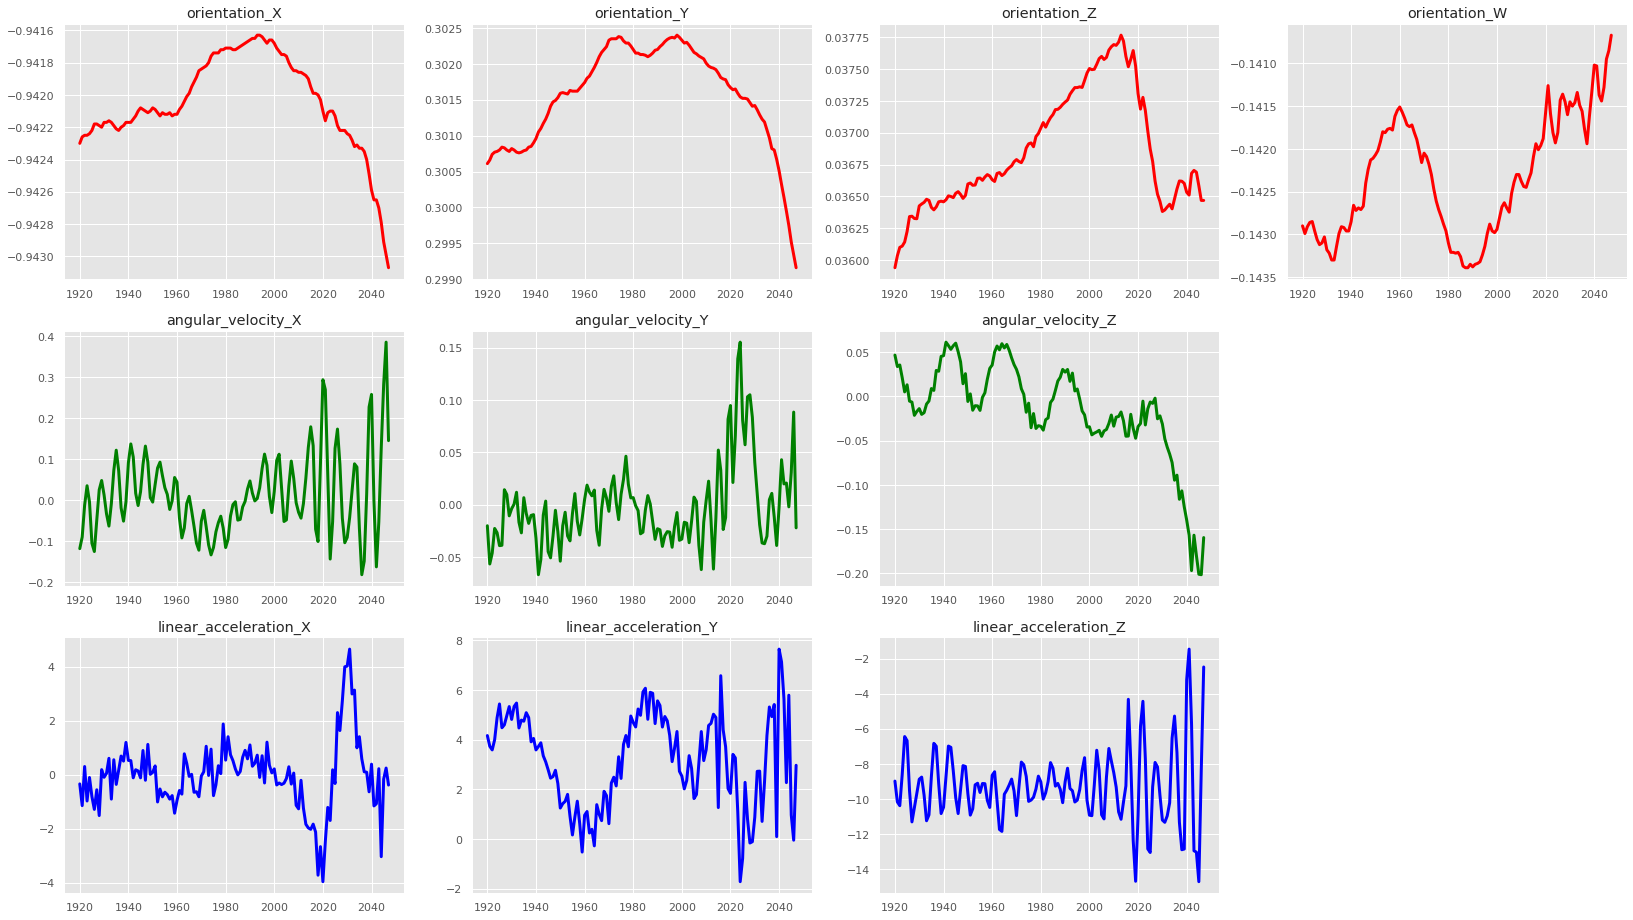

In [109]:
id_series = 15
plotSeries(id_series)

# Correlations 

<AxesSubplot:>

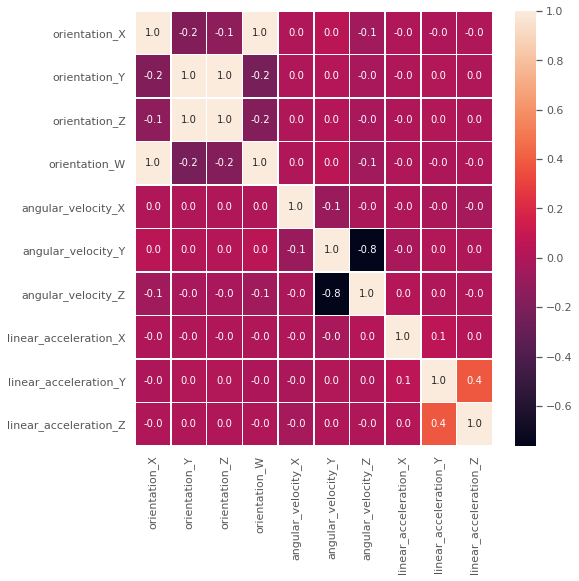

In [112]:
# Training Data
plt.subplots(figsize=(8, 8))
sns.heatmap(data.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f')

<AxesSubplot:>

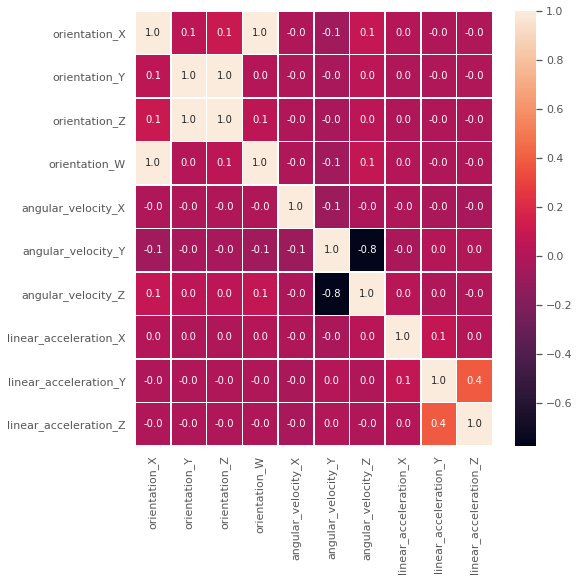

In [113]:
# Testing Data
plt.subplots(figsize=(8, 8))
sns.heatmap(test.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f')

#### Well, this is important, there is a strong correlation between:

#### angular_velocity_Z and angular_velocity_Y
#### orientation_X and orientation_Y
#### orientation_Y and orientation_Z
#### Moreover, test has different correlations than training, for example:

#### angular_velocity_Z and orientation_X: -0.1(training) and 0.1(test). Anyway, is too small in both cases, it should not be a problem

.

# Fourier Analysis

In [114]:
def prepare_data(t):
    def f(d):
        d = d.sort_values(by=['measurement_number'])
        return pd.DataFrame({
         'lx':[ d['linear_acceleration_X'].values ],
         'ly':[ d['linear_acceleration_Y'].values ],
         'lz':[ d['linear_acceleration_Z'].values ],
         'ax':[ d['angular_velocity_X'].values ],
         'ay':[ d['angular_velocity_Y'].values ],
         'az':[ d['angular_velocity_Z'].values ],
        })

    t = t.groupby('series_id').apply(f)

    def mfft(x):
        return [ x/math.sqrt(128.0) for x in np.absolute(np.fft.fft(x)) ][1:65]

    t['lx_f']=[ mfft(x) for x in t['lx'].values ]
    t['ly_f']=[ mfft(x) for x in t['ly'].values ]
    t['lz_f']=[ mfft(x) for x in t['lz'].values ]
    t['ax_f']=[ mfft(x) for x in t['ax'].values ]
    t['ay_f']=[ mfft(x) for x in t['ay'].values ]
    t['az_f']=[ mfft(x) for x in t['az'].values ]
    return t

In [116]:
t = prepare_data(data)
t = pd.merge(t, y_train[['series_id','surface','group_id']],on='series_id')
t = t.rename(columns={"surface": "y"})

In [117]:
def aggf(d, feature):    
    va= np.array(d[feature].tolist())
    mean= sum(va)/va.shape[0]
    var= sum([ (va[i,:]-mean)**2 for i in range(va.shape[0]) ])/va.shape[0]
    dev= [ math.sqrt(x) for x in var ]
    return pd.DataFrame({
        'mean': [ mean ],
        'dev' : [ dev ],
    })

display={
'hard_tiles_large_space':'r-.',
'concrete':'g-.',
'tiled':'b-.',

'fine_concrete':'r-',
'wood':'g-',
'carpet':'b-',
'soft_pvc':'y-',

'hard_tiles':'r--',
'soft_tiles':'g--',
}

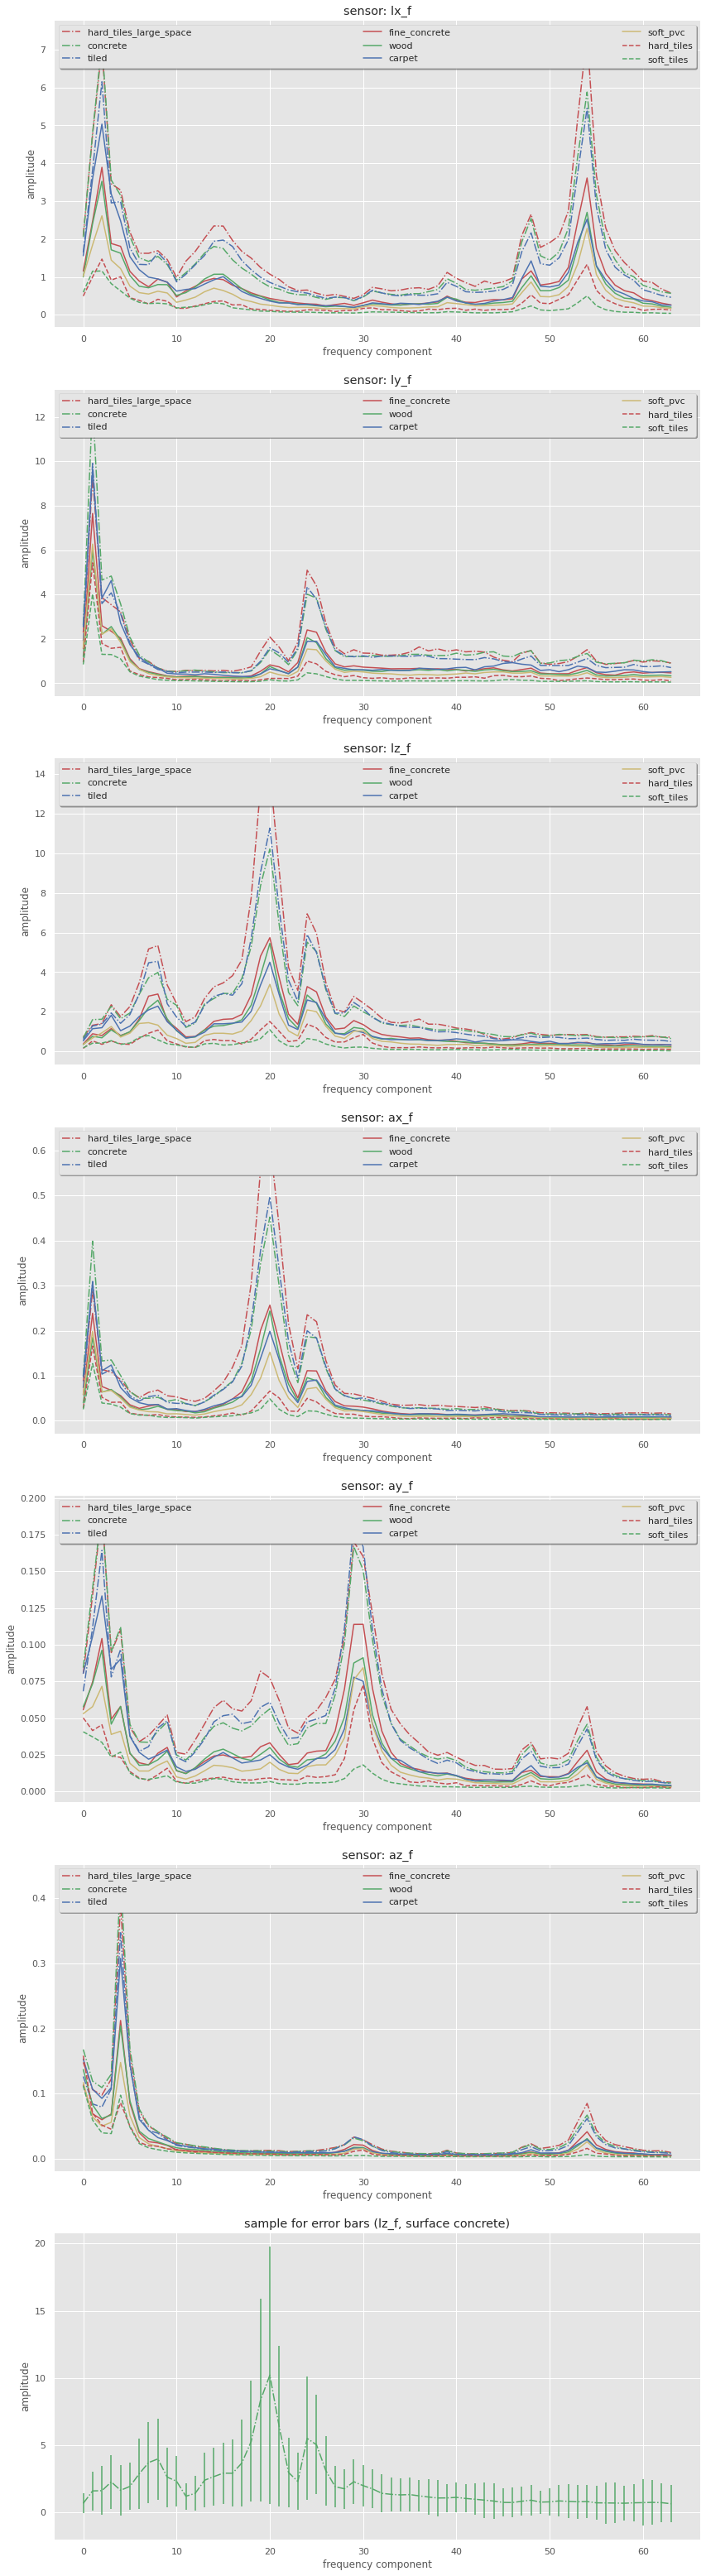

In [118]:
plt.figure(figsize=(14, 8*7))

features=['lx_f','ly_f','lz_f','ax_f','ay_f','az_f']
count=0

for feature in features:
    stat= t.groupby('y').apply(aggf,feature)
    stat.index= stat.index.droplevel(-1)
    b=[*range(len(stat.at['carpet','mean']))]

    count+=1
    plt.subplot(len(features)+1,1,count)
    for i,(k,v) in enumerate(display.items()):
        plt.plot(b, stat.at[k,'mean'], v, label=k)
        # plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
   
    leg = plt.legend(loc='best', ncol=3, mode="expand", shadow=True, fancybox=True)
    plt.title("sensor: " + feature)
    plt.xlabel("frequency component")
    plt.ylabel("amplitude")

count+=1
plt.subplot(len(features)+1,1,count)
k='concrete'
v=display[k]
feature='lz_f'
stat= t.groupby('y').apply(aggf,feature)
stat.index= stat.index.droplevel(-1)
b=[*range(len(stat.at['carpet','mean']))]

plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
plt.title("sample for error bars (lz_f, surface concrete)")
plt.xlabel("frequency component")
plt.ylabel("amplitude")

plt.show()

# Feature Engineering

In [119]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [120]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()

<Figure size 432x288 with 0 Axes>

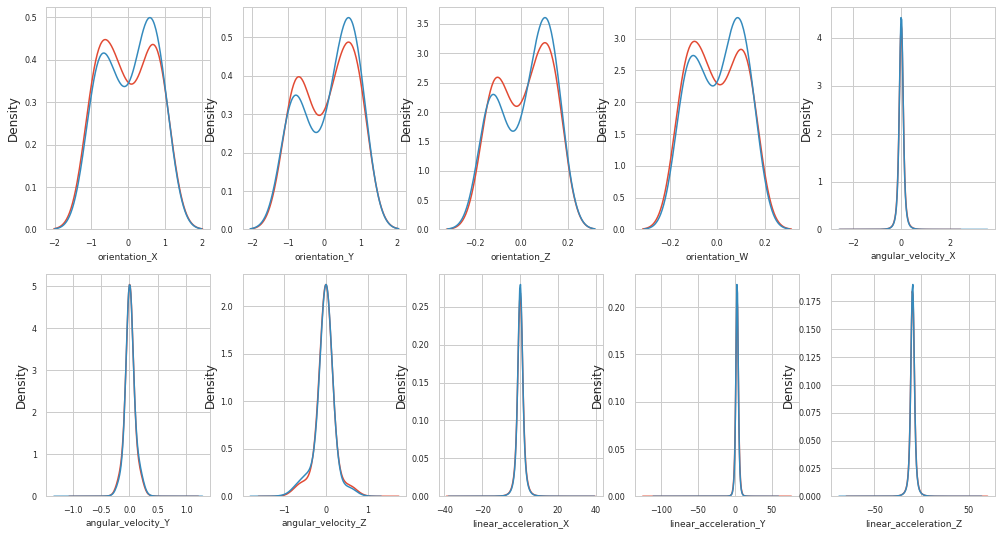

In [121]:
features = data.columns.values[3:]
plot_feature_distribution(data, test, 'train', 'test', features)

In [124]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()

<Figure size 432x288 with 0 Axes>

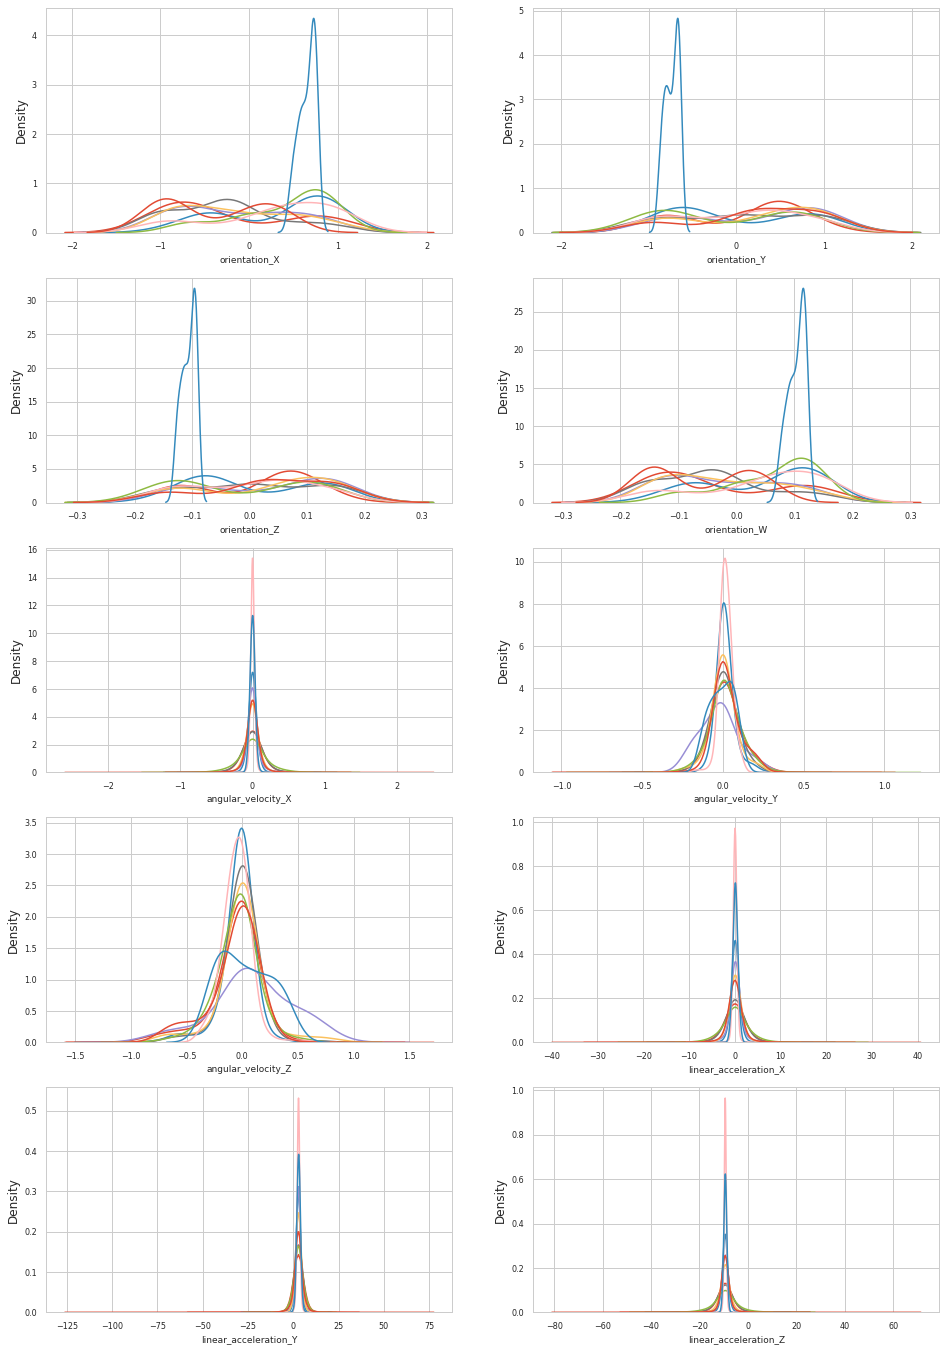

In [125]:
classes = (target['surface'].value_counts()).index
aux = data.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, aux, features)

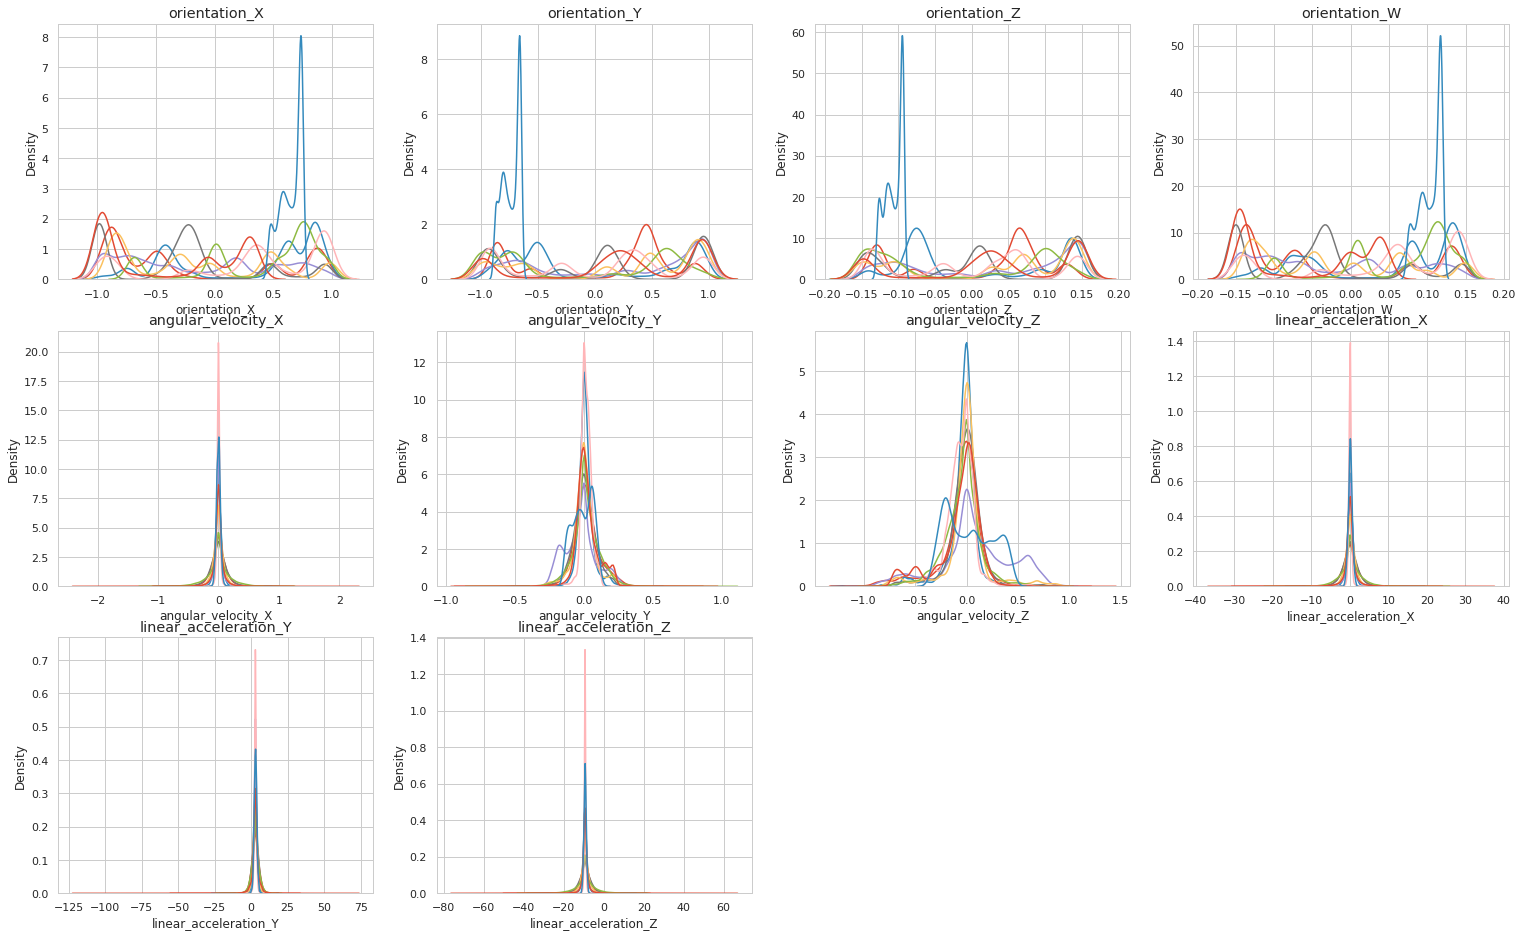

In [126]:
plt.figure(figsize=(26, 16))
for i,col in enumerate(aux.columns[3:13]):
    ax = plt.subplot(3,4,i+1)
    ax = plt.title(col)
    for surface in classes:
        surface_feature = aux[aux['surface'] == surface]
        sns.kdeplot(surface_feature[col], label = surface)

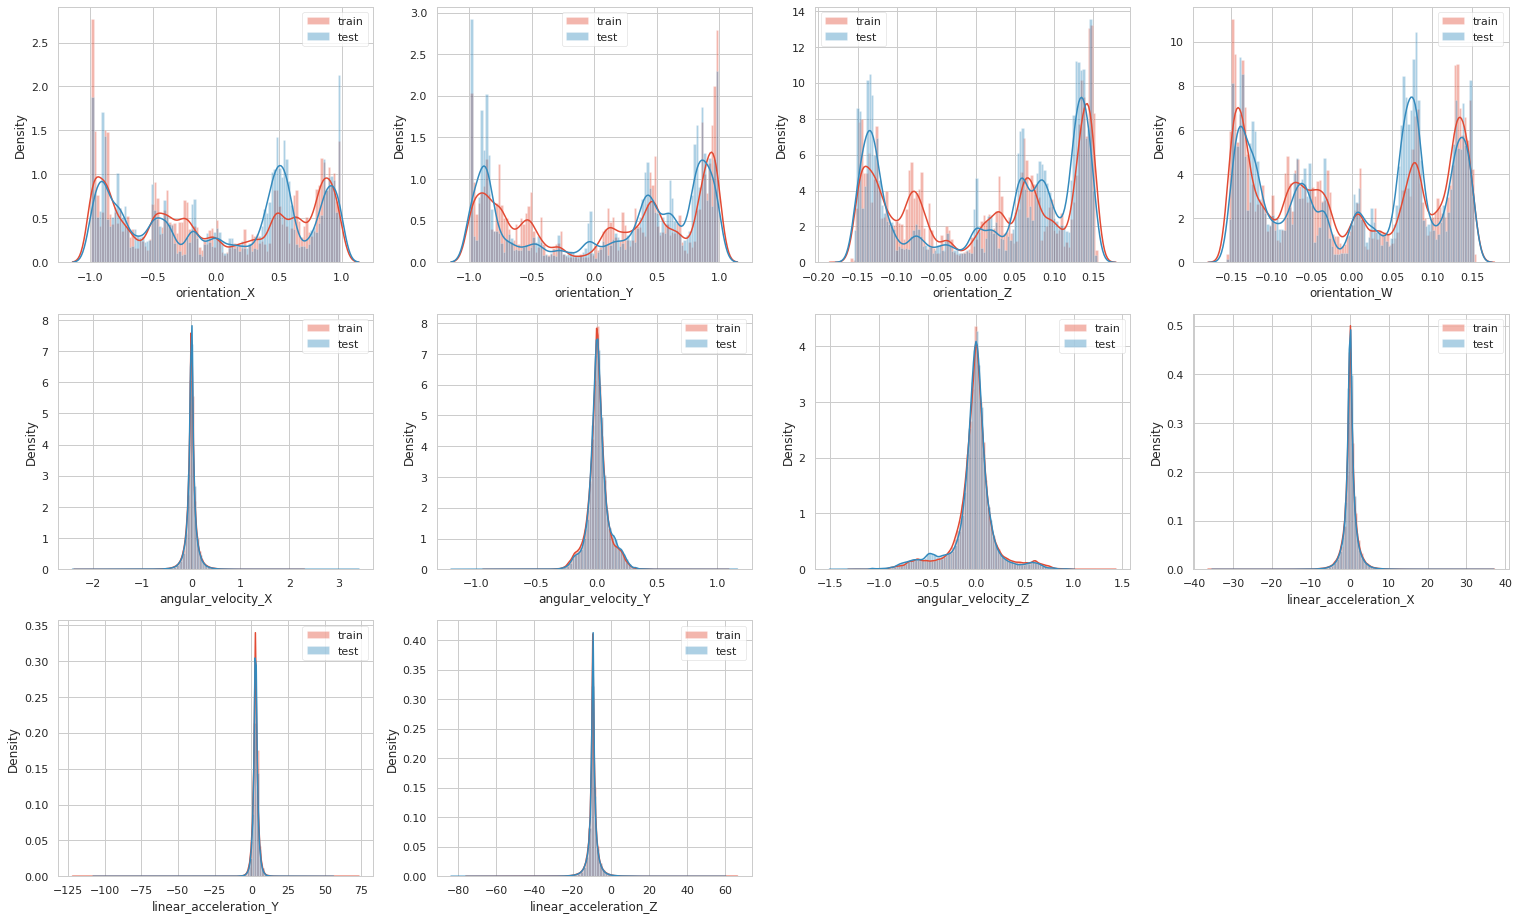

In [127]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(data.columns[3:]):
    ax = plt.subplot(3, 4, i + 1)
    sns.distplot(data[col], bins=100, label='train')
    sns.distplot(test[col], bins=100, label='test')
    ax.legend()   

In [128]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [129]:
data.skew()

row_id                   2.233564
series_id                0.000000
measurement_number       0.000000
orientation_X            0.027906
orientation_Y           -0.180998
orientation_Z           -0.175208
orientation_W            0.039368
angular_velocity_X       0.052843
angular_velocity_Y       0.112263
angular_velocity_Z      -0.275458
linear_acceleration_X    0.111975
linear_acceleration_Y   -1.093905
linear_acceleration_Z   -0.065355
dtype: float64